# 项目背景

风电机组是将风能转化为电能的发电装置，为了评判风电机组的能量转化能力，通常使用风速和机组有功功率两个参数，进行风电机组的“风速-功率”曲线（下简称为功率曲线）的绘制，通过功率曲线的形态对风电机组的发电能力进行评判，风电机组的设计核心目标是在机组工作的风速区间内，实现从空气动能到发电功率的最大程度的转化。<br/>

在功率曲线图中，横轴为风速，纵轴为风机有功功率。蓝色的数据点，每一个点为每10分钟系统采集的机组运行状态的平均值（风速及有功功率），红色的曲线为机组设计功率散点拟合得到的曲线（对应文档“机组设计功率曲线curve.csv”），通常可以通过蓝色的十分钟散点数据与设计功率曲线的位置关系判断机组发电性能是否存在异常。<br/>

图中展示了四种常见的风电机组功率曲线形态问题，分别为多线异常、功率曲线左移、功率曲线性能低下和功率曲线畸变。前面三个问题字面上比较好理解，这里仅对功率曲线畸变进行说明，功率曲线畸变指的是风机的实际功率曲线、散点在不同风速段下的表现不一致，如图中所示，在低风速段，风机的功率散点低于功率曲线，而在高风速段，风机的功率散点高于功率曲线。

<img style="width:50%" align="left" src="./机组发电性能异常.png"/> 



<span style='color:blue;font-weight:bold;font-size:1.5em'>风电机组功率异常各类型直观理解</span> <br/>
- 多线异常：在所有风速段，风机的功率散点既有低于功率曲线的情况，也有高于功率曲线的情况
- 曲线左移：在所有风速段，风机的功率散点高于功率曲线
- 曲线右移：在所有风速段，风机的功率散点低于功率曲线
- 曲线畸变：在低风速段，风机的功率散点低于功率曲线，而在高风速段，风机的功率散点高于功率曲线

# 导入包

In [1]:
import sys
sys.path.remove('/Users/Frank/.local/lib/python3.6/site-packages')

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer

In [3]:
seed = 9999
plt.style.use('ggplot')
%matplotlib inline

# 数据熟悉

In [4]:
curve = pd.read_csv("节能风电-数据题目-风电机组功率曲线异常分类问题/机组设计功率曲线curve.csv")
label = pd.read_csv("节能风电-数据题目-风电机组功率曲线异常分类问题/label.csv")

In [17]:
curve.head()

,风速,功率
0,3.0,0.0
1,3.5,26.0
2,4.0,55.0
3,4.5,86.0
4,5.0,124.0


In [10]:
label.head()

,Unnamed: 0,type
0,1101_E16,右移
1,1102_E17,分叉
2,1103_E18,NaN
3,1104_E19,NaN
4,1105_E20,NaN


In [19]:
label.groupby('type').agg('size')

type
分叉    6
右移    6
左移    6
畸变    6
dtype: int64

In [16]:
count_by_cost = label.groupby('type').apply(lambda df: df.value_counts()).unstack()
count_by_cost

type              分叉   右移   左移   畸变
type Unnamed: 0                    
分叉   1102_E17    1.0  NaN  NaN  NaN
     1402_G09    1.0  NaN  NaN  NaN
     1602_F04    1.0  NaN  NaN  NaN
     2111_D18    1.0  NaN  NaN  NaN
     2508_C04    1.0  NaN  NaN  NaN
     2601_E07    1.0  NaN  NaN  NaN
右移   1101_E16    NaN  1.0  NaN  NaN
     1205_F11    NaN  1.0  NaN  NaN
     1301_G10    NaN  1.0  NaN  NaN
     1505_G07    NaN  1.0  NaN  NaN
     1612_H04    NaN  1.0  NaN  NaN
     2203_D11    NaN  1.0  NaN  NaN
左移   1111_F22    NaN  NaN  1.0  NaN
     1606_G03    NaN  NaN  1.0  NaN
     1608_G01    NaN  NaN  1.0  NaN
     1609_H01    NaN  NaN  1.0  NaN
     2408_A04    NaN  NaN  1.0  NaN
     2511_C01    NaN  NaN  1.0  NaN
畸变   1203_F09    NaN  NaN  NaN  1.0
     1506_J01    NaN  NaN  NaN  1.0
     2102_E09    NaN  NaN  NaN  1.0
     2204_D12    NaN  NaN  NaN  1.0
     2404_B02    NaN  NaN  NaN  1.0
     2509_C03    NaN  NaN  NaN  1.0

# 观察不同功率曲线

## 正常

In [63]:
data.head()

,Time stamp,StatusBitmask,ActivePower10min,WindSpeed10min,AirTempOut10min,AirPressure10min,GeoWindDirection10min,WindTurbulenceIntensity,Windspeed10minAvg,Windspeed10minMin,...,WindspeedRotor10minAvg,WindspeedRotor10minMin,WindspeedRotor10minMax,WindspeedRotor10minVar,TurbinefaultEnergyLoss,GridFailureEnergyLoss,WeatherStopEnergyLoss,ManualStopEnergyLoss,PowerLimitedEnergyLoss,ResetTimeStamp
0,2020-09-01 00:00:00.454,104,160.815,5.41536,20.6059,82095.9,-41.0228,0.701960,5.41536,4.99748,...,5.41536,4.99748,5.88184,0.038014,28955,9,33027,83531,136177,2019-05-28 00:02:54.923
1,2020-09-01 00:10:00.454,104,147.834,5.28374,20.5008,82095.9,-39.9139,0.249032,5.28374,5.03208,...,5.28374,5.03208,5.65682,0.013158,28955,9,33027,83531,136177,2019-05-28 00:02:54.923
2,2020-09-01 00:20:00.454,104,144.120,5.24716,20.4947,82095.9,-37.8598,0.226424,5.24716,4.99358,...,5.24716,4.99358,5.63339,0.011881,28955,9,33027,83531,136177,2019-05-28 00:02:54.923
3,2020-09-01 00:30:00.455,104,158.504,5.40625,20.4509,82095.9,-31.7324,0.373653,5.40625,5.10916,...,5.40625,5.10916,5.89942,0.020201,28955,9,33027,83531,136177,2019-05-28 00:02:54.923
4,2020-09-01 00:40:00.501,104,146.498,5.26291,20.3711,82095.9,-33.3191,0.541578,5.26291,4.93823,...,5.26291,4.93823,5.78334,0.028503,28955,9,33027,83531,136177,2019-05-28 00:02:54.923


In [59]:
data[['ActivePower10min', 'WindSpeed10min']].describe()

,ActivePower10min,WindSpeed10min
count,4301.000000,4301.000000
mean,354.600270,6.192997
std,376.883155,2.603541
min,-9.976100,0.149818
25%,74.246800,4.307270
50%,227.804000,5.987050
75%,488.661000,7.674260
max,1481.990000,15.274000


Text(0, 0.5, 'Power')

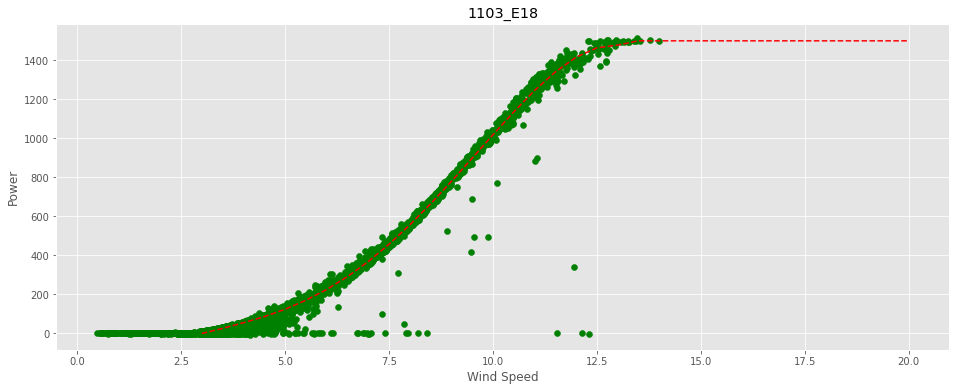

In [56]:
data = pd.read_csv("节能风电-数据题目-风电机组功率曲线异常分类问题/data/1103_E18.csv")
plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], curve['功率'], '--r')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1103_E18")
plt.xlabel("Wind Speed")
plt.ylabel("Power")

Text(0, 0.5, 'Power')

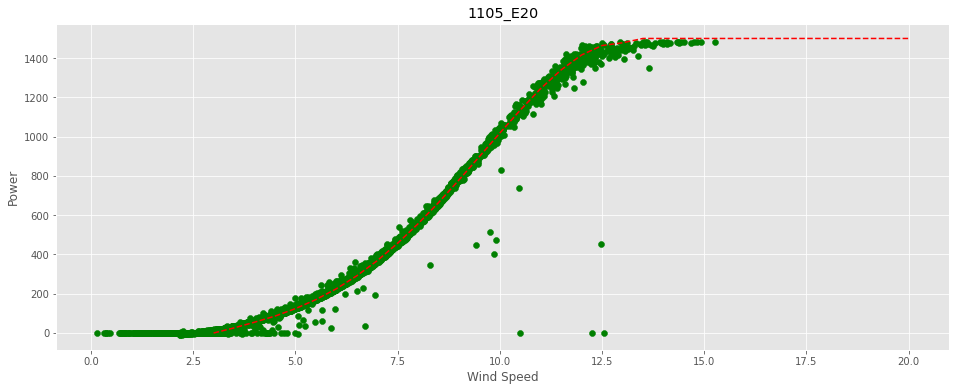

In [57]:
data = pd.read_csv("节能风电-数据题目-风电机组功率曲线异常分类问题/data/1105_E20.csv")
plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], curve['功率'], '--r')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1105_E20")
plt.xlabel("Wind Speed")
plt.ylabel("Power")

## 分叉

Text(0, 0.5, 'Power')

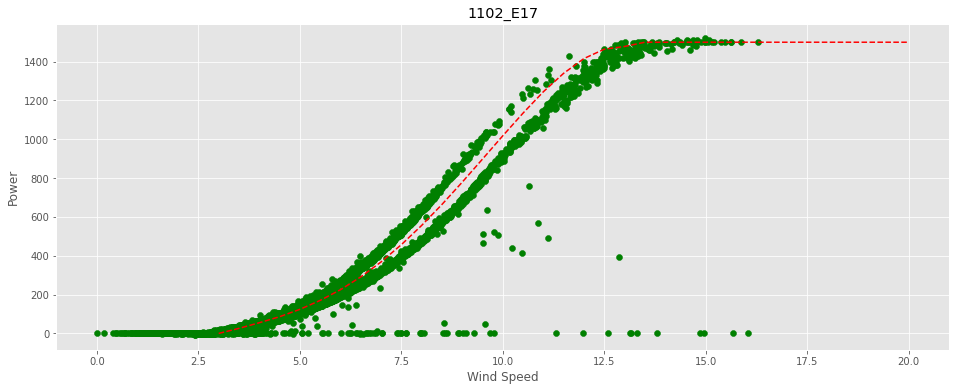

In [53]:
data = pd.read_csv("节能风电-数据题目-风电机组功率曲线异常分类问题/data/1102_E17.csv")
plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], curve['功率'], '--r')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1102_E17")
plt.xlabel("Wind Speed")
plt.ylabel("Power")

## 右移

Text(0, 0.5, 'Power')

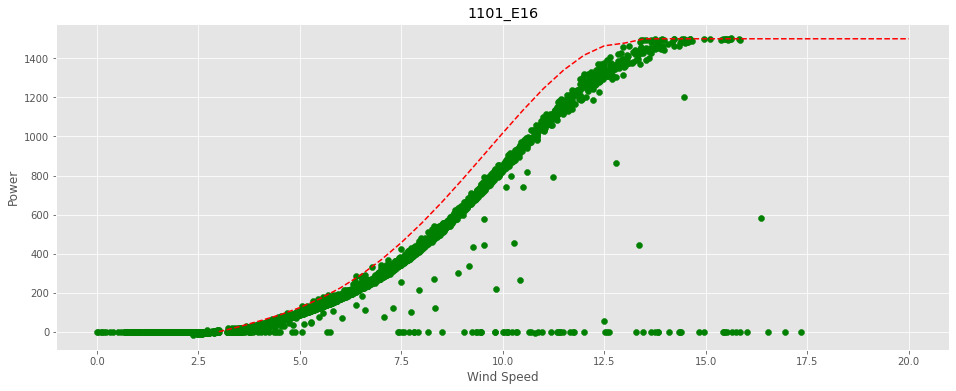

In [51]:
data = pd.read_csv("节能风电-数据题目-风电机组功率曲线异常分类问题/data/1101_E16.csv")
plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], curve['功率'], '--r')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1101_E16")
plt.xlabel("Wind Speed")
plt.ylabel("Power")

## 左移

Text(0, 0.5, 'Power')

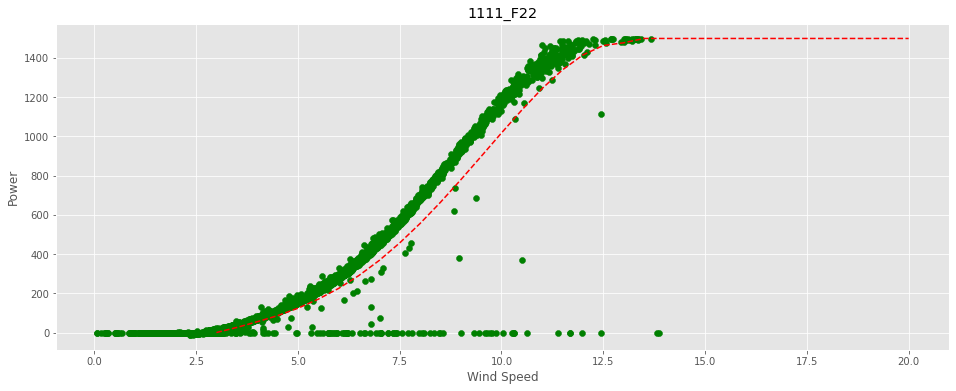

In [54]:
data = pd.read_csv("节能风电-数据题目-风电机组功率曲线异常分类问题/data/1111_F22.csv")
plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], curve['功率'], '--r')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1111_F22")
plt.xlabel("Wind Speed")
plt.ylabel("Power")

## 畸变

Text(0, 0.5, 'Power')

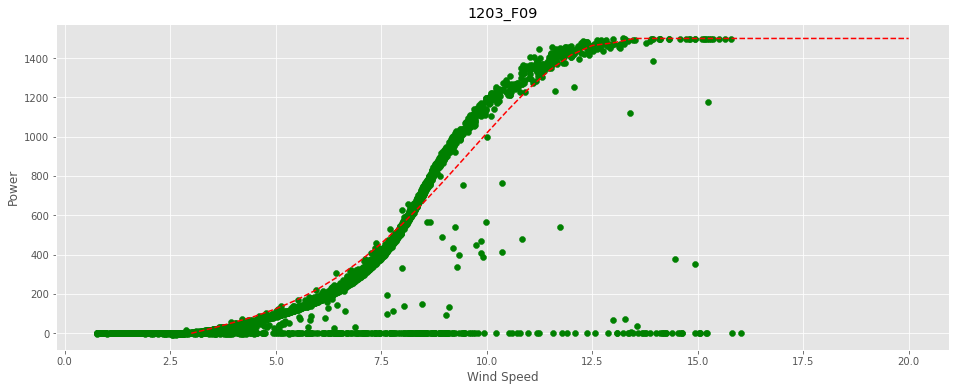

In [55]:
data = pd.read_csv("节能风电-数据题目-风电机组功率曲线异常分类问题/data/1203_F09.csv")
plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], curve['功率'], '--r')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1203_F09")
plt.xlabel("Wind Speed")
plt.ylabel("Power")

# 尝试1. 实际机组功率曲线拟合 (具体case分析)

<span style='color:blue;font-weight:bold;font-size:1.5em'>分析思路</span> <br/>
1. 我们选择合适的目标函数，然后通过非线性最小二乘法拟合每个机组的功率曲线
2. 然后通过拟合曲线得到不同风速下预测值，再计算预测值与机组设计功率残差 (设计功率减预测功率之差求和)
3. 根据残差去判断机组是否异常，以及异常分类是什么


## 正常

### 异常值处理

<span style='color:blue;font-weight:bold;font-size:1.5em'>我们为了更拟合曲线趋势，把功率小于等于0的这些数据清除掉</span> <br/>


In [96]:
data.describe()

,StatusBitmask,ActivePower10min,WindSpeed10min,AirTempOut10min,AirPressure10min,GeoWindDirection10min,WindTurbulenceIntensity,Windspeed10minAvg,Windspeed10minMin,Windspeed10minMax,...,RelWindLongMax,WindspeedRotor10minAvg,WindspeedRotor10minMin,WindspeedRotor10minMax,WindspeedRotor10minVar,TurbinefaultEnergyLoss,GridFailureEnergyLoss,WeatherStopEnergyLoss,ManualStopEnergyLoss,PowerLimitedEnergyLoss
count,4304.000000,4304.000000,4304.000000,4304.000000,4304.000000,4304.000000,4304.000000,4304.000000,4304.000000,4304.000000,...,4304.000000,4304.000000,4304.000000,4304.000000,4304.000000,4304.000000,4304.0,4304.000000,4304.000000,4304.000000
mean,58.881506,305.098716,5.908545,20.377708,82095.899930,115.503343,11.806141,5.908545,4.314707,7.550051,...,1929.857674,1884.464260,7.258827,7.353512,1.979953,1427.588058,0.0,671.220028,1812.341775,5118.651022
std,39.033702,351.851018,2.397774,4.898300,0.003408,175.781519,14.141144,2.397774,2.137053,2.868472,...,1876.836031,1883.891483,17.404046,17.404314,0.203690,8654.773764,0.0,4590.339720,7000.452163,16201.232293
min,1.000000,-7.723460,0.479648,7.256940,82095.700000,-261.909000,0.000000,0.479648,0.000000,0.921288,...,-46.143300,0.000000,0.000000,1.179310,0.019383,0.000000,0.0,0.000000,0.000000,0.000000
25%,40.000000,42.965175,4.117030,17.059525,82095.900000,3.611923,3.548800,4.117030,2.578222,5.515205,...,440.970500,381.594250,2.536785,2.509797,2.000000,463.000000,0.0,126.000000,949.000000,2219.750000
50%,40.000000,185.051500,5.649565,20.577150,82095.900000,141.327000,7.373020,5.649565,4.155625,7.248260,...,1533.200000,1430.130000,2.891275,2.909715,2.000000,463.000000,0.0,156.000000,951.000000,3299.000000
75%,104.000000,422.934750,7.318553,23.839050,82095.900000,176.312000,15.079400,7.318553,5.662520,9.271152,...,2691.805000,2646.410000,4.399287,4.420867,2.000000,616.000000,0.0,255.000000,1790.000000,4828.000000
max,238.000000,1512.130000,13.990600,33.942300,82095.900000,579.721000,316.453000,13.990600,11.540600,17.047500,...,8030.680000,8021.190000,92.543100,92.294000,3.000000,82066.000000,0.0,43441.000000,66799.000000,155344.000000


In [106]:
data[data['ActivePower10min'] <= 0]

,Time stamp,StatusBitmask,ActivePower10min,WindSpeed10min,AirTempOut10min,AirPressure10min,GeoWindDirection10min,WindTurbulenceIntensity,Windspeed10minAvg,Windspeed10minMin,...,WindspeedRotor10minAvg,WindspeedRotor10minMin,WindspeedRotor10minMax,WindspeedRotor10minVar,TurbinefaultEnergyLoss,GridFailureEnergyLoss,WeatherStopEnergyLoss,ManualStopEnergyLoss,PowerLimitedEnergyLoss,ResetTimeStamp
10,2020-09-01 01:40:00.633,72,-0.031253,2.231150,22.3332,82095.9,89.7266,21.00730,2.231150,1.188190,...,2.231150,1.188190,4.05117,0.468705,82066,0,43435,66799,155336,2017-07-04 08:51:12.133
11,2020-09-01 01:50:00.621,72,0.000000,1.738300,21.8891,82095.9,90.3974,5.32449,1.738300,1.143820,...,1.738300,1.143820,2.31803,0.092556,82066,0,43435,66799,155336,2017-07-04 08:51:12.133
12,2020-09-01 02:00:00.622,72,-0.002343,1.024960,21.6473,82095.9,82.3179,13.32860,1.024960,0.577686,...,1.024960,0.577686,1.51383,0.136612,82066,0,43435,66799,155336,2017-07-04 08:51:12.133
13,2020-09-01 02:10:00.617,77,0.000000,0.619663,21.4215,82095.9,103.5250,26.57090,0.619663,0.000000,...,0.619663,0.000000,1.17931,0.164650,82066,0,43435,66799,155336,2017-07-04 08:51:12.133
14,2020-09-01 02:20:00.617,1,-0.002002,1.088090,21.1914,82095.9,138.7180,8.42469,1.088090,0.620327,...,1.088090,0.739046,1.56939,0.091668,82066,0,43435,66799,155336,2017-07-04 08:51:12.133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4177,2020-09-30 02:50:00.856,1,-0.002050,3.356830,15.9971,82095.9,124.4170,7.71266,3.356830,2.264860,...,0.000000,91.772900,91.71000,2.000000,616,0,275,1806,5866,2017-07-04 08:51:12.133
4180,2020-09-30 03:20:00.672,40,-1.098350,2.707720,16.4333,82095.9,165.7090,13.26610,2.707720,1.527420,...,14.599700,5.041810,5.00620,2.000000,616,0,289,1806,5869,2017-07-04 08:51:12.133
4181,2020-09-30 03:30:00.840,8,0.000000,2.416480,15.7165,82095.9,156.0410,8.27595,2.416480,1.728140,...,0.000000,4.916930,5.62388,2.000000,616,0,289,1806,5869,2017-07-04 08:51:12.133
4182,2020-09-30 03:40:00.221,72,-0.071882,3.457500,15.6474,82095.9,168.6740,9.76348,3.457500,2.356830,...,0.000000,12.117000,12.07760,2.000000,616,0,289,1806,5872,2017-07-04 08:51:12.133


In [256]:
data = pd.read_csv("节能风电-数据题目-风电机组功率曲线异常分类问题/data/1103_E18.csv")
print(data.shape)
print(data[data['ActivePower10min'] == 0].shape)
print(data[data['ActivePower10min'] < 0].shape)
data = data[data['ActivePower10min'] > 0]
print(data.shape)

(4304, 100)
(150, 100)
(367, 100)
(3787, 100)


Text(0, 0.5, 'Power')

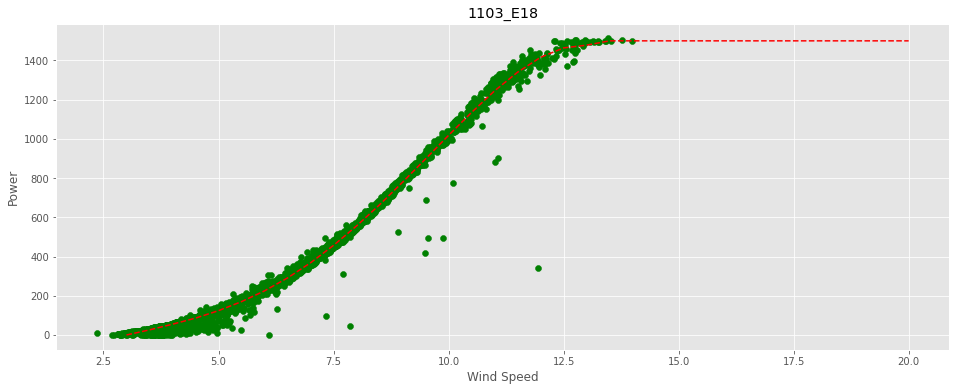

In [257]:
plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], curve['功率'], '--r')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1103_E18")
plt.xlabel("Wind Speed")
plt.ylabel("Power")

### 二项式拟合

In [143]:
# curve fit
def objective(x, a, b, c):
 return a * x + b * x**2 + c

x, y = data['WindSpeed10min'], data['ActivePower10min']
popt, _ = curve_fit(objective, x, y)
a, b, c = popt
print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))

y = -7.03318 * x + 11.39542 * x^2 + -119.72350


In [144]:
y_power = objective(data['WindSpeed10min'], a, b, c)

Text(0, 0.5, 'Power')

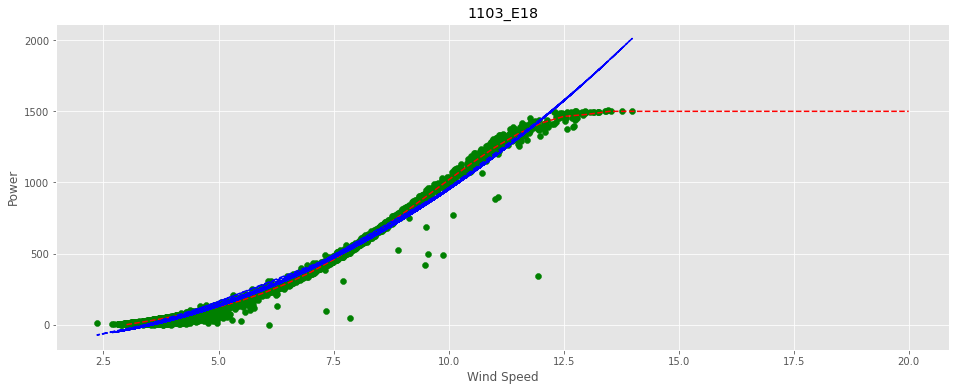

In [145]:
plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], curve['功率'], '--r')
plt.plot(data['WindSpeed10min'], y_power, '--b')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1103_E18")
plt.xlabel("Wind Speed")
plt.ylabel("Power")

In [146]:
Metrics = pd.DataFrame([['二项式',
                        mean_absolute_error(data['ActivePower10min'], y_power),
                        mean_squared_error(data['ActivePower10min'], y_power),
                        r2_score(data['ActivePower10min'], y_power)]],columns=['Model','MAE','MSE','R2-score'])
Metrics

,Model,MAE,MSE,R2-score
0,二项式,26.627907,2247.867806,0.982188


### 三项式拟合

Text(0, 0.5, 'Power')

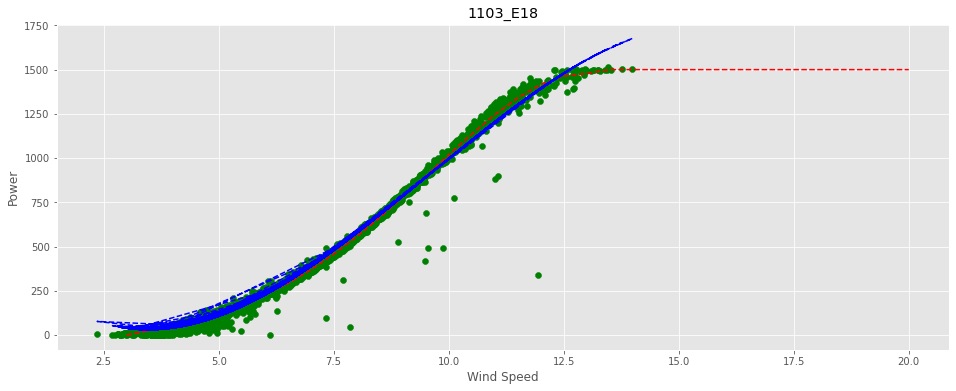

In [147]:
def objective(x, a, b, c, d):
 return (a * x) + (b * x**2) + (c * x**3) + d

x, y = data['WindSpeed10min'], data['ActivePower10min']
popt, _ = curve_fit(objective, x, y)
a, b, c, d = popt
y_power = objective(data['WindSpeed10min'], a, b, c, d)

plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], curve['功率'], '--r')
plt.plot(data['WindSpeed10min'], y_power, '--b')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1103_E18")
plt.xlabel("Wind Speed")
plt.ylabel("Power")

In [148]:
Metrics.loc[1] = ['三项式',
                   mean_absolute_error(data['ActivePower10min'], y_power),
                   mean_squared_error(data['ActivePower10min'], y_power),
                   r2_score(data['ActivePower10min'], y_power)]
Metrics

,Model,MAE,MSE,R2-score
0,二项式,26.627907,2247.867806,0.982188
1,三项式,20.182231,1295.427076,0.989735


### 四项式拟合

In [149]:
def objective(x, a, b, c, d, e):
 return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + e

x, y = data['WindSpeed10min'], data['ActivePower10min']
popt, _ = curve_fit(objective, x, y)
a, b, c, d, e = popt
y_power = objective(data['WindSpeed10min'], a, b, c, d, e)

Text(0, 0.5, 'Power')

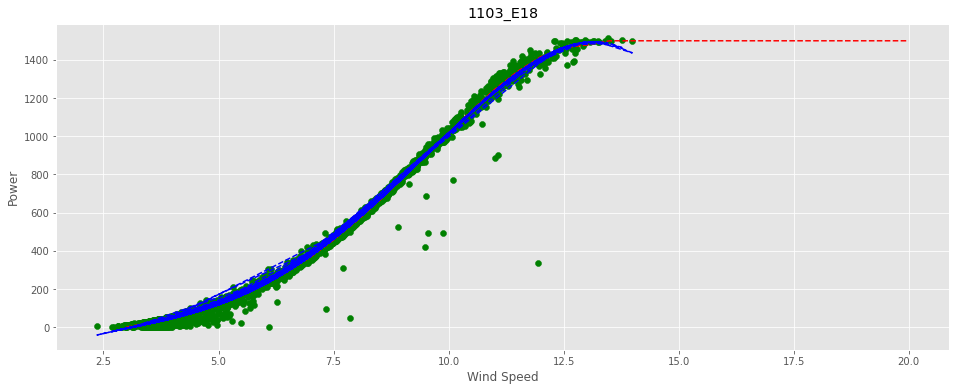

In [150]:
plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], curve['功率'], '--r')
plt.plot(data['WindSpeed10min'], y_power, '--b')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1103_E18")
plt.xlabel("Wind Speed")
plt.ylabel("Power")

In [151]:
Metrics.loc[2] = ['四项式',
                   mean_absolute_error(data['ActivePower10min'], y_power),
                   mean_squared_error(data['ActivePower10min'], y_power),
                   r2_score(data['ActivePower10min'], y_power)]
Metrics

,Model,MAE,MSE,R2-score
0,二项式,26.627907,2247.867806,0.982188
1,三项式,20.182231,1295.427076,0.989735
2,四项式,14.325662,1046.943777,0.991704


### 五项式拟合

In [258]:
def objective(x, a, b, c, d, e, f):
 return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

x, y = data['WindSpeed10min'], data['ActivePower10min']
popt, _ = curve_fit(objective, x, y)
a, b, c, d, e, f = popt
y_power = objective(data['WindSpeed10min'], a, b, c, d, e, f)

Text(0, 0.5, 'Power')

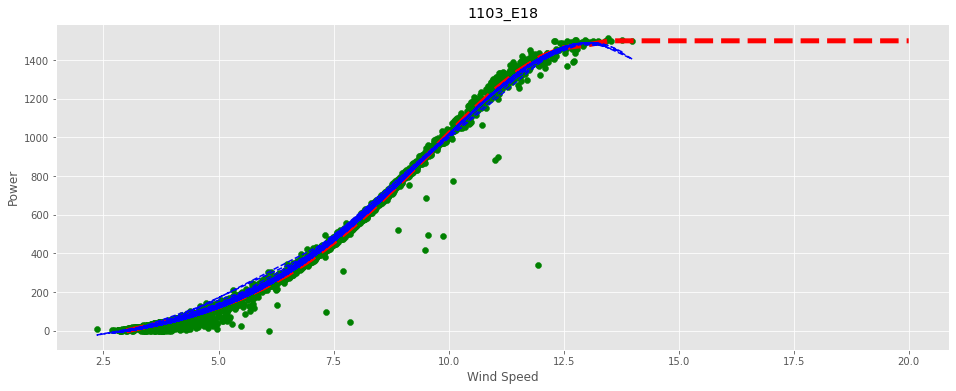

In [259]:
plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], curve['功率'], '--r', linewidth=5)
plt.plot(data['WindSpeed10min'], y_power, '--b')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1103_E18")
plt.xlabel("Wind Speed")
plt.ylabel("Power")

In [260]:
Metrics.loc[3] = ['五项式',
                   mean_absolute_error(data['ActivePower10min'], y_power),
                   mean_squared_error(data['ActivePower10min'], y_power),
                   r2_score(data['ActivePower10min'], y_power)]
Metrics

,Model,MAE,MSE,R2-score
0,二项式,26.627907,2247.867806,0.982188
1,三项式,20.182231,1295.427076,0.989735
2,四项式,14.325662,1046.943777,0.991704
3,五项式,14.319548,1044.175531,0.991726


### 拟合功率跟机组设计功率计算残差

In [155]:
x_predict = curve[curve['风速'] <= np.max(data['WindSpeed10min'])]['风速']
y_actual = curve[curve['风速'] <= np.max(data['WindSpeed10min'])]['功率']
y_predict = objective(x_predict, a, b, c, d, e, f)

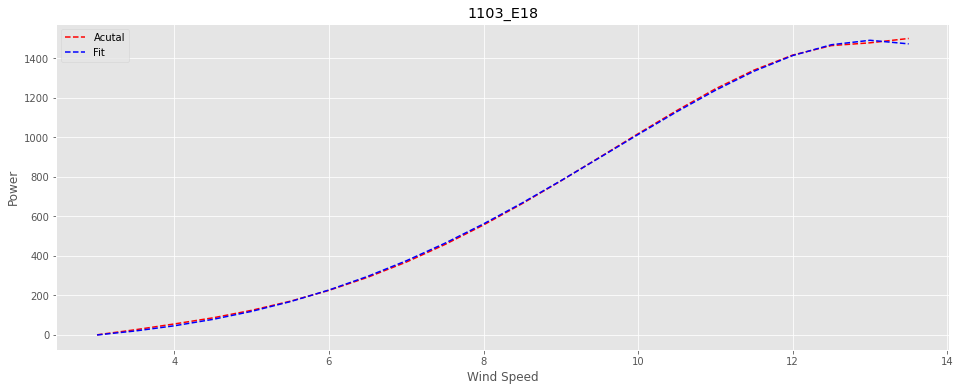

In [156]:
plt.figure(figsize=(16, 6))
plt.plot(x_predict, y_actual, '--r')
plt.plot(x_predict, y_predict, '--b')
plt.title("1103_E18")
plt.xlabel("Wind Speed")
plt.ylabel("Power")
plt.legend(["Acutal", "Fit"])

In [157]:
def residual(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.sum(actual - pred)

residual(y_actual, y_predict)

39.62746437551672

In [261]:
residual(data['ActivePower10min'], objective(data['WindSpeed10min'], a, b, c, d, e, f))

3.429357093409635e-06

<span style='color:blue;font-weight:bold;font-size:1.5em'>根据上面计算，在正常情况下，残差和趋近于0</span> <br/>


## 右移

### 五项式拟合

In [266]:
data = pd.read_csv("节能风电-数据题目-风电机组功率曲线异常分类问题/data/1101_E16.csv")
data.describe()

,StatusBitmask,ActivePower10min,WindSpeed10min,AirTempOut10min,AirPressure10min,GeoWindDirection10min,WindTurbulenceIntensity,Windspeed10minAvg,Windspeed10minMin,Windspeed10minMax,...,RelWindLongMax,WindspeedRotor10minAvg,WindspeedRotor10minMin,WindspeedRotor10minMax,WindspeedRotor10minVar,TurbinefaultEnergyLoss,GridFailureEnergyLoss,WeatherStopEnergyLoss,ManualStopEnergyLoss,PowerLimitedEnergyLoss
count,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,...,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.0,4305.000000,4305.000000,4305.000000
mean,57.100813,323.228078,6.600268,18.056950,82095.899977,125.457171,12.315075,6.183380,4.591477,7.791975,...,2091.617124,2149.765209,7.881754,7.923918,1.978935,6123.844599,0.0,807.163763,2946.609059,6457.623461
std,41.246906,359.106417,2.830723,4.766312,0.001524,103.003747,42.222572,2.624058,2.298457,3.181953,...,1960.317918,1970.118244,18.758121,18.817912,0.208376,5535.601512,0.0,5427.164285,7836.407731,25223.821293
min,1.000000,-16.438100,0.000000,5.704570,82095.800000,-150.930000,0.000000,0.000000,0.000000,0.016209,...,-43.381700,0.000000,0.000000,0.978051,0.015321,0.000000,0.0,0.000000,0.000000,0.000000
25%,40.000000,49.369200,4.473563,14.946900,82095.900000,86.118800,3.451160,4.180900,2.590410,5.505060,...,557.927000,611.474000,2.594820,2.568960,2.000000,5494.000000,0.0,168.000000,537.000000,2039.000000
50%,40.000000,201.887000,6.403447,18.003200,82095.900000,111.699000,7.100400,5.984530,4.564380,7.510970,...,1683.070000,1743.040000,2.836820,2.858060,2.000000,5547.000000,0.0,218.000000,537.000000,3633.000000
75%,72.000000,457.433000,8.233190,21.325900,82095.900000,141.320000,14.419800,7.694570,6.072350,9.498640,...,2881.950000,2948.370000,4.230300,4.270620,2.000000,7646.000000,0.0,304.000000,4864.000000,5788.000000
max,239.000000,1501.590000,17.343844,30.115400,82095.900000,665.664000,2596.070000,16.209200,12.095500,25.066700,...,8345.650000,8429.430000,92.202600,92.070200,3.000000,52855.000000,0.0,51376.000000,73303.000000,240617.000000


In [267]:
print(data.shape)
print(data[data['ActivePower10min'] == 0].shape)
print(data[data['ActivePower10min'] < 0].shape)
data = data[data['ActivePower10min'] > 0]
print(data.shape)

(4305, 100)
(134, 100)
(390, 100)
(3781, 100)


Text(0, 0.5, 'Power')

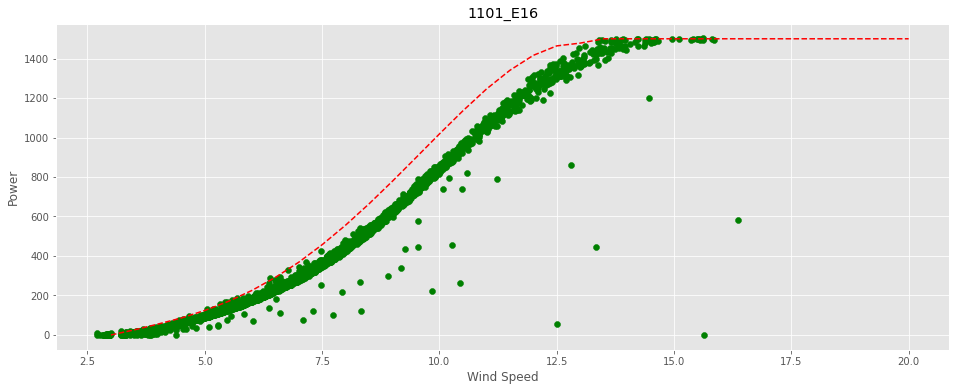

In [268]:
plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], curve['功率'], '--r')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1101_E16")
plt.xlabel("Wind Speed")
plt.ylabel("Power")

Text(0, 0.5, 'Power')

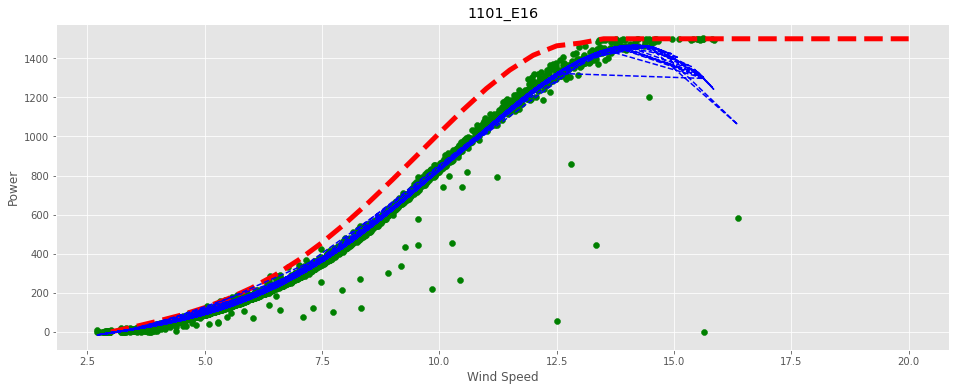

In [269]:
def objective(x, a, b, c, d, e, f):
 return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f


x, y = data['WindSpeed10min'], data['ActivePower10min']
popt, _ = curve_fit(objective, x, y)
a, b, c, d, e, f = popt
y_power = objective(data['WindSpeed10min'], a, b, c, d, e, f)

plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], curve['功率'], '--r', linewidth=5)
plt.plot(data['WindSpeed10min'], y_power, '--b')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1101_E16")
plt.xlabel("Wind Speed")
plt.ylabel("Power")

### 拟合功率跟机组设计功率计算残差

In [270]:
x_predict = curve[curve['风速'] <= 13.5]['风速']
y_actual = curve[curve['风速'] <= 13.5]['功率']
y_predict = objective(x_predict, a, b, c, d, e, f)

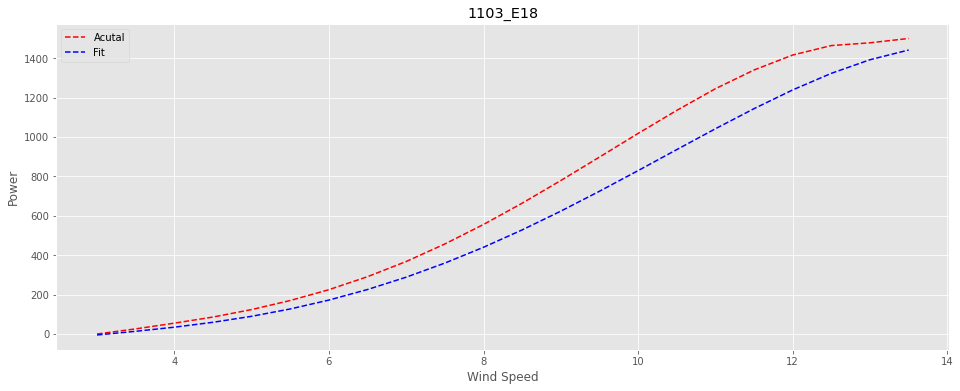

In [271]:
plt.figure(figsize=(16, 6))
plt.plot(x_predict, y_actual, '--r')
plt.plot(x_predict, y_predict, '--b')
plt.title("1103_E18")
plt.xlabel("Wind Speed")
plt.ylabel("Power")
plt.legend(["Acutal", "Fit"])

In [272]:
def residual(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.sum(actual - pred)

residual(y_actual, y_predict)

2265.6995303487765

In [273]:
residual(data['ActivePower10min'], objective(data['WindSpeed10min'], a, b, c, d, e, f))

-0.0005348411086742999

<span style='color:blue;font-weight:bold;font-size:1.5em'>根据上面计算，在右移情况下，残差和很大</span> <br/>


## 左移

### 五项式拟合

In [248]:
data = pd.read_csv("节能风电-数据题目-风电机组功率曲线异常分类问题/data/1111_F22.csv")
data.describe()

,StatusBitmask,ActivePower10min,WindSpeed10min,AirTempOut10min,AirPressure10min,GeoWindDirection10min,WindTurbulenceIntensity,Windspeed10minAvg,Windspeed10minMin,Windspeed10minMax,...,RelWindLongMax,WindspeedRotor10minAvg,WindspeedRotor10minMin,WindspeedRotor10minMax,WindspeedRotor10minVar,TurbinefaultEnergyLoss,GridFailureEnergyLoss,WeatherStopEnergyLoss,ManualStopEnergyLoss,PowerLimitedEnergyLoss
count,4283.000000,4283.000000,4283.000000,4283.000000,4283.000000,4283.000000,4283.000000,4283.000000,4283.000000,4283.000000,...,4283.000000,4283.000000,4283.000000,4283.000000,4283.000000,4283.000000,4283.0,4283.000000,4283.000000,4283.000000
mean,54.853374,318.316042,5.618405,17.029712,82095.899883,213.292968,11.754698,6.022850,4.471170,7.583394,...,2032.044256,2098.248101,8.068615,8.077272,1.980646,3182.454588,0.0,481.999533,1879.653047,4467.350222
std,39.776818,368.640365,2.401331,4.776162,0.005509,173.921051,20.149410,2.607449,2.317524,3.133308,...,1984.433561,2001.973786,18.823899,18.884072,0.210919,15287.126819,0.0,2718.158497,9820.429674,19466.290906
min,1.000000,-12.435100,0.067868,4.800030,82095.600000,-69.294200,0.000000,0.067868,0.000000,0.730684,...,-38.136700,0.000000,0.684410,1.374770,0.006287,0.000000,0.0,0.000000,0.000000,0.000000
25%,40.000000,50.526200,3.844374,13.867600,82095.900000,8.701325,3.324835,4.133735,2.497190,5.282865,...,545.766500,606.344000,2.618925,2.602220,2.000000,71.000000,0.0,115.000000,418.000000,1292.000000
50%,40.000000,186.999000,5.393358,16.968800,82095.900000,281.376000,6.604460,5.799310,4.391860,7.177290,...,1567.600000,1637.160000,2.934790,2.948090,2.000000,413.000000,0.0,238.000000,826.000000,2273.000000
75%,40.000000,436.137000,6.968532,20.289300,82095.900000,345.699500,13.310600,7.493045,5.882060,9.274040,...,2746.140000,2824.390000,4.292790,4.295565,2.000000,413.000000,0.0,269.000000,1595.000000,3671.000000
max,237.000000,1497.410000,13.862208,29.065200,82095.900000,646.906000,506.309000,14.905600,12.844700,42.271400,...,8199.470000,8305.210000,92.252000,92.133700,3.000000,142427.000000,0.0,25737.000000,92978.000000,184935.000000


In [249]:
print(data.shape)
print(data[data['ActivePower10min'] == 0].shape)
print(data[data['ActivePower10min'] < 0].shape)
data = data[data['ActivePower10min'] > 0]
print(data.shape)

(4283, 100)
(183, 100)
(370, 100)
(3730, 100)


Text(0, 0.5, 'Power')

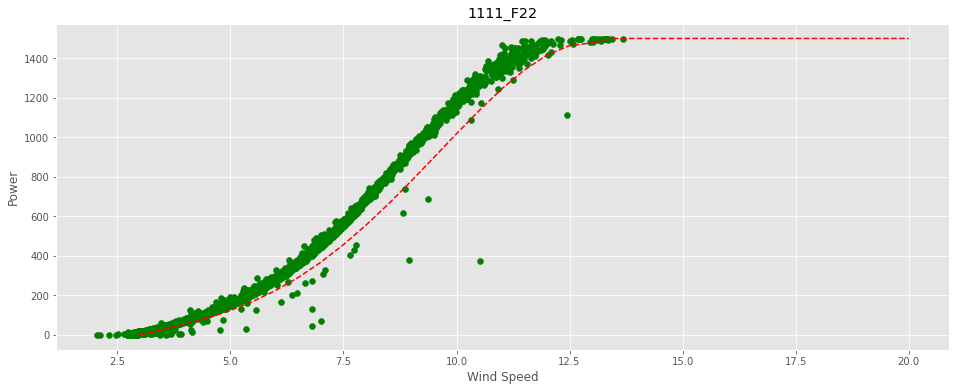

In [250]:
plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], curve['功率'], '--r')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1111_F22")
plt.xlabel("Wind Speed")
plt.ylabel("Power")

Text(0, 0.5, 'Power')

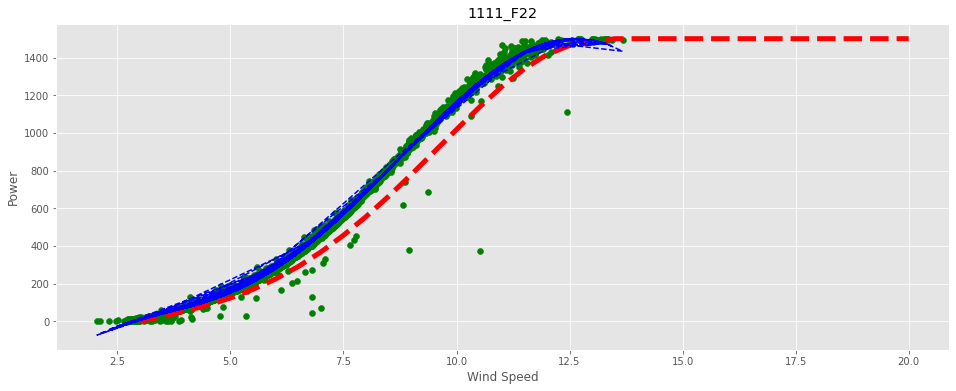

In [251]:
def objective(x, a, b, c, d, e, f):
 return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f


x, y = data['WindSpeed10min'], data['ActivePower10min']
popt, _ = curve_fit(objective, x, y)
a, b, c, d, e, f = popt
y_power = objective(data['WindSpeed10min'], a, b, c, d, e, f)

plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], curve['功率'], '--r', linewidth=5)
plt.plot(data['WindSpeed10min'], y_power, '--b')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1111_F22")
plt.xlabel("Wind Speed")
plt.ylabel("Power")

### 拟合功率跟机组设计功率计算残差

In [252]:
x_predict = curve[curve['风速'] <= 13.5]['风速']
y_actual = curve[curve['风速'] <= 13.5]['功率']
y_predict = objective(x_predict, a, b, c, d, e, f)

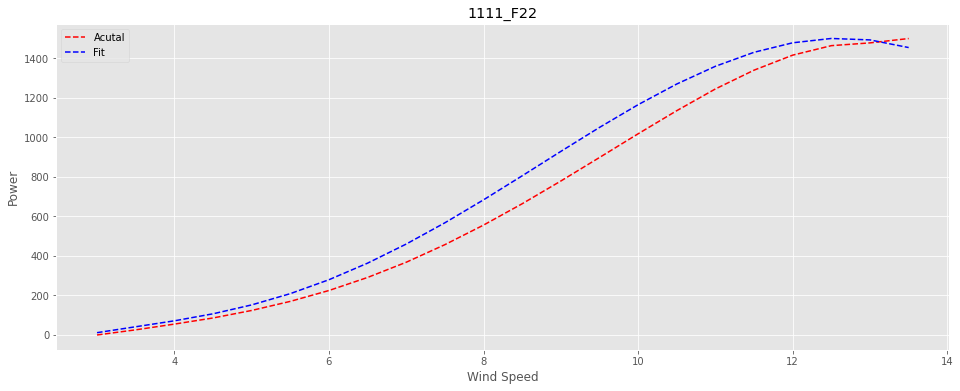

In [253]:
plt.figure(figsize=(16, 6))
plt.plot(x_predict, y_actual, '--r')
plt.plot(x_predict, y_predict, '--b')
plt.title("1111_F22")
plt.xlabel("Wind Speed")
plt.ylabel("Power")
plt.legend(["Acutal", "Fit"])

In [254]:
def residual(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.sum(actual - pred)

residual(y_actual, y_predict)

-1588.586056588404

In [255]:
residual(data['ActivePower10min'], objective(data['WindSpeed10min'], a, b, c, d, e, f))

-1.265795435756445e-05

<span style='color:blue;font-weight:bold;font-size:1.5em'>根据上面计算，在左移情况下，残差和是个很小的负数</span> <br/>


## 畸变

### 五项式拟合

In [233]:
data = pd.read_csv("节能风电-数据题目-风电机组功率曲线异常分类问题/data/2102_E09.csv")
data.describe()

,StatusBitmask,ActivePower10min,WindSpeed10min,AirTempOut10min,AirPressure10min,GeoWindDirection10min,WindTurbulenceIntensity,Windspeed10minAvg,Windspeed10minMin,Windspeed10minMax,...,RelWindLongMax,WindspeedRotor10minAvg,WindspeedRotor10minMin,WindspeedRotor10minMax,WindspeedRotor10minVar,TurbinefaultEnergyLoss,GridFailureEnergyLoss,WeatherStopEnergyLoss,ManualStopEnergyLoss,PowerLimitedEnergyLoss
count,4320.000000,4320.000000,4320.000000,4320.000000,4.320000e+03,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,...,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.00000,4320.0,4320.000000,4320.000000,4320.000000
mean,56.014352,374.883745,6.475476,17.545852,8.209590e+04,-13.160464,11.142655,6.298367,4.828614,7.841650,...,2287.964548,2380.757497,7.150745,7.307969,2.000926,92.72338,0.0,331.989815,1132.666667,3672.842361
std,40.073466,395.614352,2.507017,4.742943,2.619648e-09,224.839672,15.002644,2.695954,2.426475,3.157802,...,2094.897918,2115.230982,16.978178,17.071600,0.056927,32.61900,0.0,121.740965,738.252426,1419.682315
min,1.000000,-14.249800,0.231015,5.745950,8.209590e+04,-425.077000,0.219288,0.229683,0.000000,0.864702,...,-42.981700,0.000000,1.922930,1.868850,1.000000,31.00000,0.0,133.000000,31.000000,1279.000000
25%,40.000000,62.108775,4.597655,14.444200,8.209590e+04,-179.374500,2.868755,4.209523,2.874355,5.440340,...,623.712500,712.984500,2.630453,2.590813,2.000000,63.00000,0.0,232.000000,331.000000,2544.500000
50%,40.000000,243.255500,6.641392,17.386650,8.209590e+04,-137.071000,6.444765,6.135300,4.761425,7.604835,...,1816.220000,1910.405000,2.851030,2.873750,2.000000,81.00000,0.0,367.000000,1107.000000,3586.000000
75%,68.000000,550.062750,8.017792,20.824350,8.209590e+04,174.176500,13.625175,7.963495,6.446708,9.870538,...,3219.225000,3322.007500,4.263393,4.300302,2.000000,117.00000,0.0,443.000000,1994.000000,4994.000000
max,235.000000,1493.970000,16.000644,29.053300,8.209590e+04,588.144000,346.017000,16.001000,13.556900,18.645200,...,8171.840000,8308.810000,92.654200,92.704800,3.000000,147.00000,0.0,497.000000,1995.000000,5972.000000


In [234]:
print(data.shape)
print(data[data['ActivePower10min'] == 0].shape)
print(data[data['ActivePower10min'] < 0].shape)
data = data[data['ActivePower10min'] > 0]
print(data.shape)

(4320, 100)
(150, 100)
(386, 100)
(3784, 100)


Text(0, 0.5, 'Power')

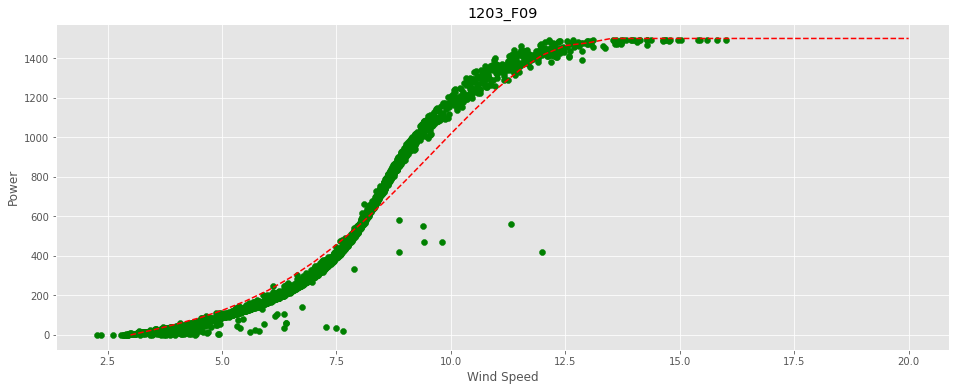

In [235]:
plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], curve['功率'], '--r')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1203_F09")
plt.xlabel("Wind Speed")
plt.ylabel("Power")

Text(0, 0.5, 'Power')

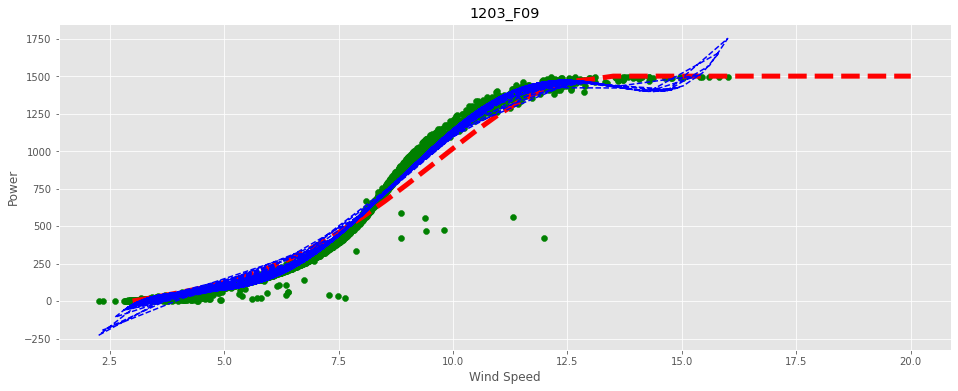

In [236]:
def objective(x, a, b, c, d, e, f):
 return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f


x, y = data['WindSpeed10min'], data['ActivePower10min']
popt, _ = curve_fit(objective, x, y)
a, b, c, d, e, f = popt
y_power = objective(data['WindSpeed10min'], a, b, c, d, e, f)

plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], curve['功率'], '--r', linewidth=5)
plt.plot(data['WindSpeed10min'], y_power, '--b')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1203_F09")
plt.xlabel("Wind Speed")
plt.ylabel("Power")

### 拟合功率跟机组设计功率计算残差

In [237]:
x_predict = curve[curve['风速'] <= 13.5]['风速']
y_actual = curve[curve['风速'] <= 13.5]['功率']
y_predict = objective(x_predict, a, b, c, d, e, f)

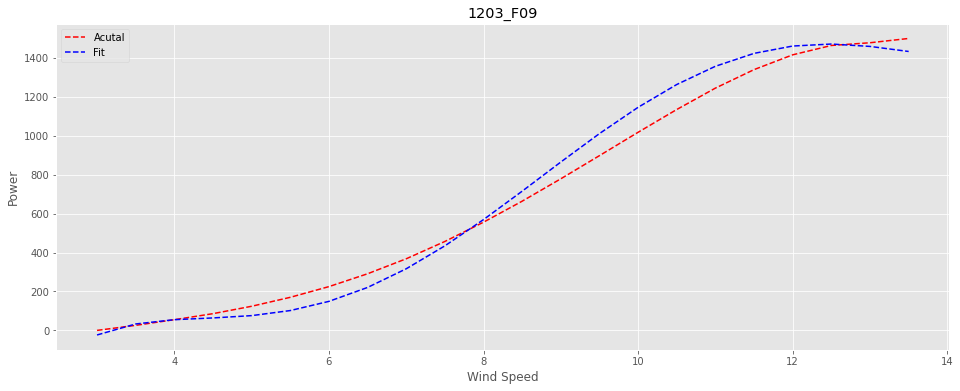

In [238]:
plt.figure(figsize=(16, 6))
plt.plot(x_predict, y_actual, '--r')
plt.plot(x_predict, y_predict, '--b')
plt.title("1203_F09")
plt.xlabel("Wind Speed")
plt.ylabel("Power")
plt.legend(["Acutal", "Fit"])

In [239]:
def residual(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.sum(actual - pred)

residual(y_actual, y_predict)

-308.7118443318518

In [240]:
residual(data['ActivePower10min'], objective(data['WindSpeed10min'], a, b, c, d, e, f))

-5.663750926032662e-07

<span style='color:blue;font-weight:bold;font-size:1.5em'>根据上面计算，在畸变情况下，残差和是个偏小的负数或偏小的正数</span> <br/>


## 分叉

### 五项式拟合

In [241]:
data = pd.read_csv("节能风电-数据题目-风电机组功率曲线异常分类问题/data/1102_E17.csv")
data.describe()

,StatusBitmask,ActivePower10min,WindSpeed10min,AirTempOut10min,AirPressure10min,GeoWindDirection10min,WindTurbulenceIntensity,Windspeed10minAvg,Windspeed10minMin,Windspeed10minMax,...,RelWindLongMax,WindspeedRotor10minAvg,WindspeedRotor10minMin,WindspeedRotor10minMax,WindspeedRotor10minVar,TurbinefaultEnergyLoss,GridFailureEnergyLoss,WeatherStopEnergyLoss,ManualStopEnergyLoss,PowerLimitedEnergyLoss
count,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,...,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000
mean,58.467596,347.399664,6.277885,17.846920,82095.899907,-70.484003,12.337076,6.237200,4.724330,7.771296,...,2192.474225,2211.004868,8.019970,8.161837,1.980095,952.331010,0.056911,828.069454,1934.801394,7621.957027
std,42.157134,379.334214,2.737768,4.758554,0.004819,188.182347,92.476099,2.618927,2.323434,3.120568,...,2024.832055,2028.134671,19.253478,19.231379,0.204941,5947.561524,0.530452,4588.914052,10462.906841,45926.669673
min,1.000000,-8.017010,0.003047,5.458460,82095.600000,-450.263000,0.000000,0.003207,0.000000,0.487886,...,-147.893000,0.000000,0.000000,1.406960,0.010825,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,61.480000,4.268550,14.736900,82095.900000,-204.847000,3.090740,4.272770,2.869180,5.543850,...,632.668000,656.491000,2.545310,2.523440,2.000000,227.000000,0.000000,294.000000,622.000000,1378.000000
50%,40.000000,221.131000,6.053096,17.834100,82095.900000,-169.578000,6.501640,6.058570,4.696060,7.492090,...,1769.950000,1790.670000,2.753310,2.786820,2.000000,227.000000,0.000000,370.000000,632.000000,2599.000000
75%,104.000000,488.279000,7.680607,21.072900,82095.900000,104.398000,13.169500,7.760020,6.186810,9.493780,...,2997.710000,3016.700000,4.171910,4.248620,2.000000,227.000000,0.000000,402.000000,1478.000000,4295.000000
max,232.000000,1519.330000,16.290855,29.697500,82095.900000,553.442000,6002.450000,15.515100,12.830000,19.722200,...,8262.370000,8286.880000,92.513500,92.690500,3.000000,56019.000000,5.000000,43586.000000,99316.000000,435326.000000


In [242]:
print(data.shape)
print(data[data['ActivePower10min'] == 0].shape)
print(data[data['ActivePower10min'] < 0].shape)
data = data[data['ActivePower10min'] > 0]
print(data.shape)

(4305, 100)
(145, 100)
(346, 100)
(3814, 100)


Text(0, 0.5, 'Power')

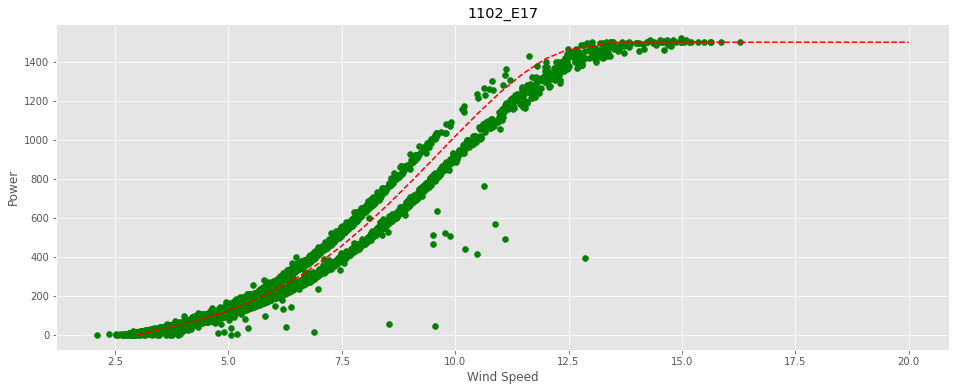

In [243]:
plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], curve['功率'], '--r')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1102_E17")
plt.xlabel("Wind Speed")
plt.ylabel("Power")

Text(0, 0.5, 'Power')

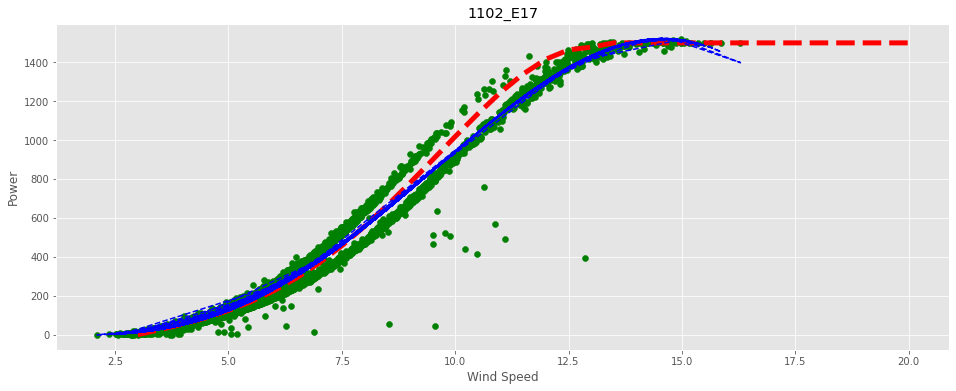

In [244]:
def objective(x, a, b, c, d, e, f):
 return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f


x, y = data['WindSpeed10min'], data['ActivePower10min']
popt, _ = curve_fit(objective, x, y)
a, b, c, d, e, f = popt
y_power = objective(data['WindSpeed10min'], a, b, c, d, e, f)

plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], curve['功率'], '--r', linewidth=5)
plt.plot(data['WindSpeed10min'], y_power, '--b')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1102_E17")
plt.xlabel("Wind Speed")
plt.ylabel("Power")

### 拟合功率跟机组设计功率计算残差

In [245]:
x_predict = curve[curve['风速'] <= 13.5]['风速']
y_actual = curve[curve['风速'] <= 13.5]['功率']
y_predict = objective(x_predict, a, b, c, d, e, f)

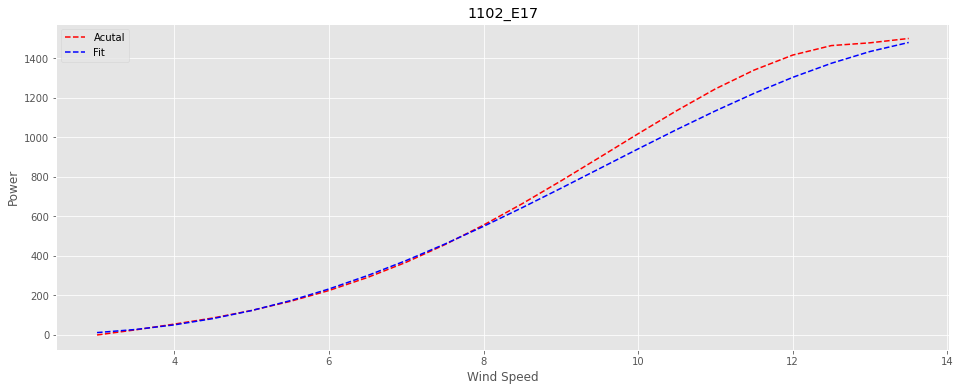

In [246]:
plt.figure(figsize=(16, 6))
plt.plot(x_predict, y_actual, '--r')
plt.plot(x_predict, y_predict, '--b')
plt.title("1102_E17")
plt.xlabel("Wind Speed")
plt.ylabel("Power")
plt.legend(["Acutal", "Fit"])

In [218]:
def residual(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.sum(actual - pred)

residual(y_actual, y_predict)

749.1632349211493

In [247]:
residual(data['ActivePower10min'], objective(data['WindSpeed10min'], a, b, c, d, e, f))

0.0004148283551330678

## 结论 (该方法不可用)

<span style='color:orange;font-weight:bold;font-size:1.5em'>根据上面曲线拟合和残差计算，可以得出上面方法不能很好的进行分类的结论，具体原因如下：</span> <br/>
1. 对分叉曲线完全不能用该方法拟合，遇到分叉数据无法得到正确结论 <br/>
2. 虽能对畸变情况拟合出较好的曲线，但计算出的残差范围不确定，有可能接近左移或右移甚至正常的残差，无法很好得进行分类


# 尝试2. 设计机组功率曲线拟合

<span style='color:blue;font-weight:bold;font-size:1.5em'>分析思路</span> <br/>
1. 我们选择合适的目标函数，然后通过非线性最小二乘法拟合设计机组的功率曲线
2. 然后通过拟合曲线预测机组在不同风速下的设计功率，计算该设计功率与机组实际功率差值
3. 根据该机组的最终差值分布去判断异常分类


## 拟合设计机组功率曲线

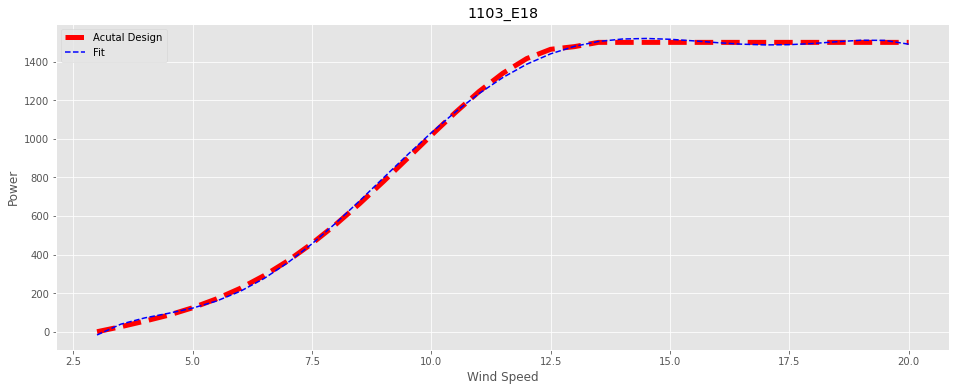

In [302]:
def objective(x, a, b, c, d, e, f, g):
 return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + (f * x**6) + g

x, y = curve['风速'], curve['功率']
popt, _ = curve_fit(objective, x, y)
a, b, c, d, e, f, g = popt
y_power = objective(curve['风速'], a, b, c, d, e, f, g)

plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], curve['功率'], '--r', linewidth=5)
plt.plot(curve['风速'], y_power, '--b')
# plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1103_E18")
plt.xlabel("Wind Speed")
plt.ylabel("Power")
plt.legend(["Acutal Design", "Fit"])

## 正常

In [453]:
data = pd.read_csv("节能风电-数据题目-风电机组功率曲线异常分类问题/data/1106_E21.csv")
print(data.shape)
print(data[data['ActivePower10min'] == 0].shape)
print(data[data['ActivePower10min'] < 0].shape)
data = data[data['ActivePower10min'] > 0]
print(data.shape)

(4248, 100)
(166, 100)
(399, 100)
(3683, 100)


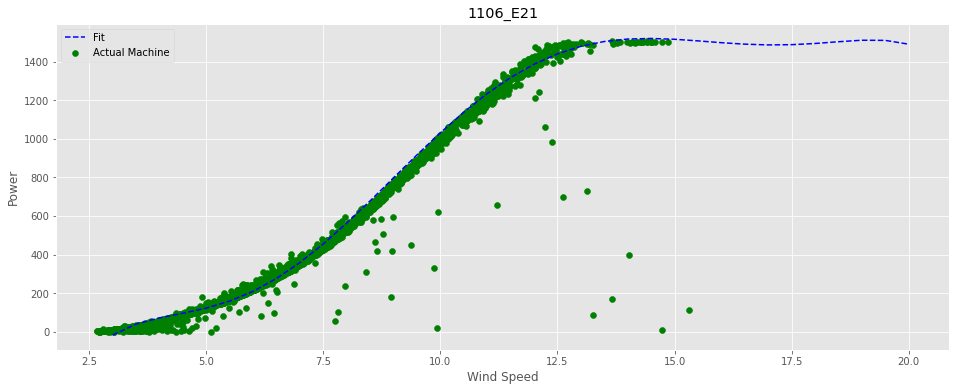

In [454]:
plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], y_power, '--b')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1106_E21")
plt.xlabel("Wind Speed")
plt.ylabel("Power")
plt.legend(["Fit", "Actual Machine"])

In [455]:
compare = data.loc[:, ['WindSpeed10min', 'ActivePower10min']]
compare['PredictDesignPower'] = objective(compare['WindSpeed10min'], a, b, c, d, e, f, g)
compare['DiffPower'] = compare['PredictDesignPower'] - compare['ActivePower10min']
compare

,WindSpeed10min,ActivePower10min,PredictDesignPower,DiffPower
0,5.36355,150.846,147.538748,-3.307252
1,5.12426,129.189,130.223043,1.034043
2,5.15618,132.169,132.369847,0.200847
3,5.27462,142.239,140.765026,-1.473974
4,4.92536,113.527,117.846531,4.319531
...,...,...,...,...
4243,6.50264,288.270,276.537774,-11.732226
4244,6.53165,291.497,280.907751,-10.589249
4245,6.61029,306.029,293.021816,-13.007184
4246,6.02780,227.832,212.733102,-15.098898


In [456]:
compare.describe()

,WindSpeed10min,ActivePower10min,PredictDesignPower,DiffPower
count,3683.000000,3683.000000,3683.000000,3683.000000
mean,6.572813,370.552829,382.731946,12.179117
std,2.320706,363.863982,376.073742,66.175117
min,2.667690,0.046285,-76.943140,-86.266683
25%,4.843795,108.724500,113.216290,-8.071457
50%,6.186380,243.319000,232.411890,6.393302
75%,7.808215,488.942000,520.586271,19.702592
max,15.309200,1508.810000,1520.363439,1510.744204


In [457]:
print(compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5)].shape)
print(compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5) & (compare['DiffPower'] >= 20)].shape)
print(compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5) & (compare['DiffPower'] <= -20)].shape)
low = compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5)].shape[0]
low_posdiff = compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5) & (compare['DiffPower'] >= 20)].shape[0]
low_negdiff = compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5) & (compare['DiffPower'] <= -20)].shape[0]
low_negdiff_ratio = low_negdiff / low
low_posdiff_ratio = low_posdiff / low
print("low_negdiff_ratio: ", low_negdiff_ratio)
print("low_posdiff_ratio: ", low_posdiff_ratio)

print('\n')

print(compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5)].shape)
print(compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5) & (compare['DiffPower'] >= 20)].shape)
print(compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5) & (compare['DiffPower'] <= -20)].shape)
high = compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5)].shape[0]
high_posdiff = compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5) & (compare['DiffPower'] >= 20)].shape[0]
high_negdiff = compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5) & (compare['DiffPower'] <= -20)].shape[0]
high_negdiff_ratio = high_negdiff / high
high_posdiff_ratio = high_posdiff / high
print("high_negdiff_ratio: ", high_negdiff_ratio)
print("high_posdiff_ratio: ", high_posdiff_ratio)

(2618, 4)
(170, 4)
(216, 4)
low_negdiff_ratio:  0.0825057295645531
low_posdiff_ratio:  0.06493506493506493


(999, 4)
(712, 4)
(49, 4)
high_negdiff_ratio:  0.04904904904904905
high_posdiff_ratio:  0.7127127127127127


## 右移

(4305, 100)
(134, 100)
(390, 100)
(3781, 100)


,WindSpeed10min,ActivePower10min,PredictDesignPower,DiffPower
0,6.131753,181.2210,225.448126,44.227126
1,6.113520,176.9350,223.167131,46.232131
2,5.993370,166.7480,208.676403,41.928403
3,6.102606,176.2110,221.812105,45.601105
4,5.994964,167.8560,208.862554,41.006554
...,...,...,...,...
4300,5.570548,135.5640,164.994348,29.430348
4301,5.115563,98.6843,129.646285,30.961985
4302,6.262325,200.7480,242.416269,41.668269
4303,6.510458,230.7770,277.710153,46.933153


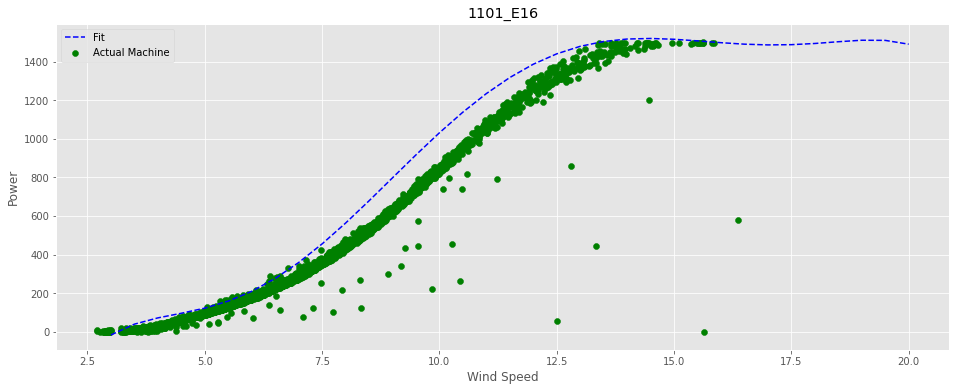

In [373]:
data = pd.read_csv("节能风电-数据题目-风电机组功率曲线异常分类问题/data/1101_E16.csv")
print(data.shape)
print(data[data['ActivePower10min'] == 0].shape)
print(data[data['ActivePower10min'] < 0].shape)
data = data[data['ActivePower10min'] > 0]
print(data.shape)

plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], y_power, '--b')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1101_E16")
plt.xlabel("Wind Speed")
plt.ylabel("Power")
plt.legend(["Fit", "Actual Machine"])

compare = data.loc[:, ['WindSpeed10min', 'ActivePower10min']]
compare['PredictDesignPower'] = objective(compare['WindSpeed10min'], a, b, c, d, e, f, g)
compare['DiffPower'] = compare['PredictDesignPower'] - compare['ActivePower10min']
compare

In [374]:
compare.describe()

,WindSpeed10min,ActivePower10min,PredictDesignPower,DiffPower
count,3781.000000,3781.000000,3781.000000,3781.000000
mean,7.017969,368.136998,450.955137,82.818139
std,2.482280,360.915071,403.234946,74.148865
min,2.703740,0.070500,-69.278525,-80.476725
25%,5.180437,104.195000,134.033347,34.133301
50%,6.747923,254.246000,315.152389,55.893259
75%,8.384584,505.755000,651.420731,126.397921
max,16.358909,1501.590000,1520.363362,1504.633265


In [364]:
print(compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5)].shape)
print(compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5) & (compare['DiffPower'] >= 20)].shape)
print(compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5) & (compare['DiffPower'] <= -20)].shape)
low = compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5)].shape[0]
low_posdiff = compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5) & (compare['DiffPower'] >= 20)].shape[0]
low_negdiff = compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5) & (compare['DiffPower'] <= -20)].shape[0]
low_negdiff_ratio = low_negdiff / low
low_posdiff_ratio = low_posdiff / low
print("low_negdiff_ratio: ", low_negdiff_ratio)
print("low_posdiff_ratio: ", low_posdiff_ratio)

print('\n')

print(compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5)].shape)
print(compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5) & (compare['DiffPower'] >= 20)].shape)
print(compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5) & (compare['DiffPower'] <= -20)].shape)
high = compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5)].shape[0]
high_posdiff = compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5) & (compare['DiffPower'] >= 20)].shape[0]
high_negdiff = compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5) & (compare['DiffPower'] <= -20)].shape[0]
high_negdiff_ratio = high_negdiff / high
high_posdiff_ratio = high_posdiff / high
print("high_negdiff_ratio: ", high_negdiff_ratio)
print("high_posdiff_ratio: ", high_posdiff_ratio)

(2333, 4)
(2158, 4)
(39, 4)
low_negdiff_ratio:  0.016716673810544362
low_posdiff_ratio:  0.9249892841834548


(1304, 4)
(1304, 4)
(0, 4)
high_negdiff_ratio:  0.0
high_posdiff_ratio:  1.0


## 左移

(4283, 100)
(183, 100)
(370, 100)
(3730, 100)


,WindSpeed10min,ActivePower10min,PredictDesignPower,DiffPower
0,5.135748,164.016,130.990241,-33.025759
1,5.065189,155.701,126.372633,-29.328367
2,5.243675,174.693,138.504359,-36.188641
3,5.442964,197.133,153.948584,-43.184416
4,5.314522,183.952,143.752770,-40.199230
...,...,...,...,...
4278,5.496523,211.439,158.471051,-52.967949
4279,4.500809,100.031,95.774971,-4.256029
4280,5.240187,182.107,138.252624,-43.854376
4281,6.347269,334.084,254.050663,-80.033337


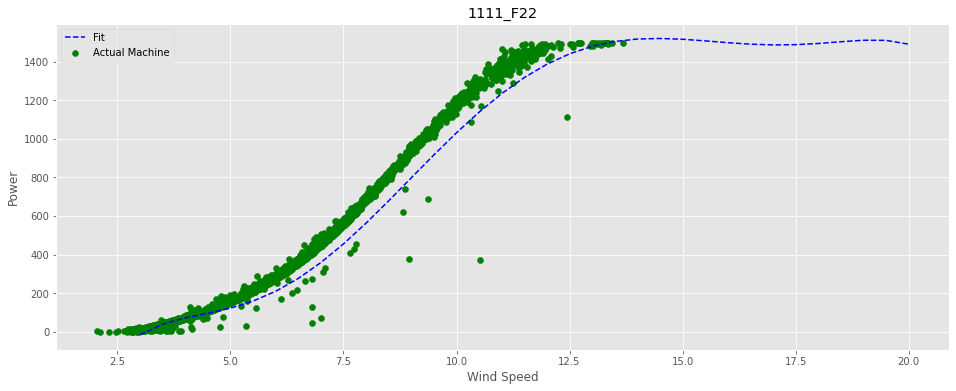

In [385]:
data = pd.read_csv("节能风电-数据题目-风电机组功率曲线异常分类问题/data/1111_F22.csv")
print(data.shape)
print(data[data['ActivePower10min'] == 0].shape)
print(data[data['ActivePower10min'] < 0].shape)
data = data[data['ActivePower10min'] > 0]
print(data.shape)

plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], y_power, '--b')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1111_F22")
plt.xlabel("Wind Speed")
plt.ylabel("Power")
plt.legend(["Fit", "Actual Machine"])

compare = data.loc[:, ['WindSpeed10min', 'ActivePower10min']]
compare['PredictDesignPower'] = objective(compare['WindSpeed10min'], a, b, c, d, e, f, g)
compare['DiffPower'] = compare['PredictDesignPower'] - compare['ActivePower10min']
compare

In [317]:
compare.describe()

,WindSpeed10min,ActivePower10min,PredictDesignPower,DiffPower
count,3730.000000,3730.000000,3730.000000,3730.000000
mean,6.011295,365.584566,305.126509,-60.458057
std,2.176302,372.476580,336.796757,53.481959
min,2.049590,0.100665,-265.791534,-267.419154
25%,4.388056,98.109700,90.467703,-98.621136
50%,5.670633,235.176500,174.331427,-58.702392
75%,7.125453,482.377000,381.652331,-16.705151
max,13.673325,1497.410000,1510.258220,768.693556


In [366]:
print(compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5)].shape)
print(compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5) & (compare['DiffPower'] >= 20)].shape)
print(compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5) & (compare['DiffPower'] <= -20)].shape)
low = compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5)].shape[0]
low_posdiff = compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5) & (compare['DiffPower'] >= 20)].shape[0]
low_negdiff = compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5) & (compare['DiffPower'] <= -20)].shape[0]
low_negdiff_ratio = low_negdiff / low
low_posdiff_ratio = low_posdiff / low
print("low_negdiff_ratio: ", low_negdiff_ratio)
print("low_posdiff_ratio: ", low_posdiff_ratio)

print('\n')

print(compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5)].shape)
print(compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5) & (compare['DiffPower'] >= 20)].shape)
print(compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5) & (compare['DiffPower'] <= -20)].shape)
high = compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5)].shape[0]
high_posdiff = compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5) & (compare['DiffPower'] >= 20)].shape[0]
high_negdiff = compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5) & (compare['DiffPower'] <= -20)].shape[0]
high_negdiff_ratio = high_negdiff / high
high_posdiff_ratio = high_posdiff / high
print("high_negdiff_ratio: ", high_negdiff_ratio)
print("high_posdiff_ratio: ", high_posdiff_ratio)

(2951, 4)
(35, 4)
(1953, 4)
low_negdiff_ratio:  0.6618095560826839
low_posdiff_ratio:  0.011860386309725517


(749, 4)
(9, 4)
(738, 4)
high_negdiff_ratio:  0.9853137516688919
high_posdiff_ratio:  0.012016021361815754


## 分叉

(4202, 100)
(156, 100)
(331, 100)
(3715, 100)


,WindSpeed10min,ActivePower10min,PredictDesignPower,DiffPower
0,4.708267,113.0450,105.992247,-7.052753
1,4.549018,99.6113,98.082545,-1.528755
2,4.392733,89.5726,90.686343,1.113743
3,4.184836,75.2691,80.916933,5.647833
4,4.285374,82.5539,85.669864,3.115964
...,...,...,...,...
4197,4.728266,79.0476,107.025588,27.977988
4198,4.766937,84.4169,109.054130,24.637230
4199,5.192733,114.7270,134.887344,20.160344
4200,5.491647,137.4300,158.052527,20.622527


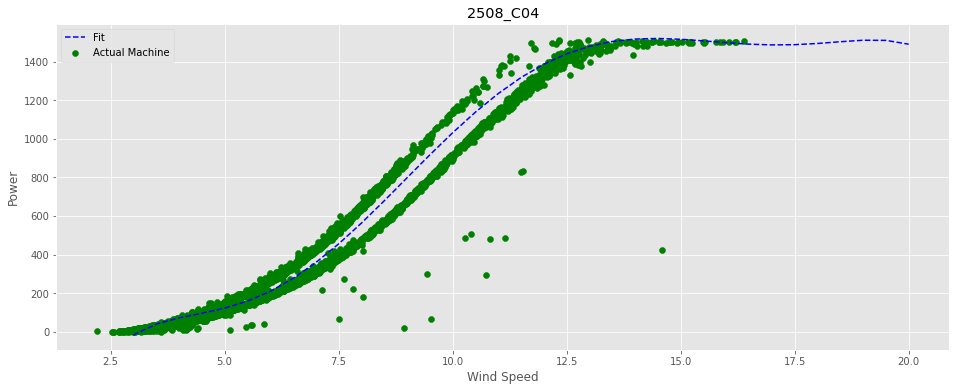

In [387]:
data = pd.read_csv("节能风电-数据题目-风电机组功率曲线异常分类问题/data/2508_C04.csv")
print(data.shape)
print(data[data['ActivePower10min'] == 0].shape)
print(data[data['ActivePower10min'] < 0].shape)
data = data[data['ActivePower10min'] > 0]
print(data.shape)

plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], y_power, '--b')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("2508_C04")
plt.xlabel("Wind Speed")
plt.ylabel("Power")
plt.legend(["Fit", "Actual Machine"])

compare = data.loc[:, ['WindSpeed10min', 'ActivePower10min']]
compare['PredictDesignPower'] = objective(compare['WindSpeed10min'], a, b, c, d, e, f, g)
compare['DiffPower'] = compare['PredictDesignPower'] - compare['ActivePower10min']
compare

In [389]:
compare.describe()

,WindSpeed10min,ActivePower10min,PredictDesignPower,DiffPower
count,3715.000000,3715.000000,3715.000000,3715.000000
mean,6.901010,430.558340,437.425414,6.867074
std,2.575052,405.306323,419.424267,75.889292
min,2.202869,0.073462,-207.407247,-209.015857
25%,5.031671,123.126000,124.255862,-54.070821
50%,6.491478,288.678000,274.870643,12.124026
75%,8.275199,621.888500,625.928769,36.738686
max,16.380630,1511.290000,1520.359393,1098.750109


In [388]:
print(compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5)].shape)
print(compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5) & (compare['DiffPower'] >= 20)].shape)
print(compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5) & (compare['DiffPower'] <= -20)].shape)
low = compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5)].shape[0]
low_posdiff = compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5) & (compare['DiffPower'] >= 20)].shape[0]
low_negdiff = compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5) & (compare['DiffPower'] <= -20)].shape[0]
low_negdiff_ratio = low_negdiff / low
low_posdiff_ratio = low_posdiff / low
print("low_negdiff_ratio: ", low_negdiff_ratio)
print("low_posdiff_ratio: ", low_posdiff_ratio)

print('\n')

print(compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5)].shape)
print(compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5) & (compare['DiffPower'] >= 20)].shape)
print(compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5) & (compare['DiffPower'] <= -20)].shape)
high = compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5)].shape[0]
high_posdiff = compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5) & (compare['DiffPower'] >= 20)].shape[0]
high_negdiff = compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5) & (compare['DiffPower'] <= -20)].shape[0]
high_negdiff_ratio = high_negdiff / high
high_posdiff_ratio = high_posdiff / high
print("high_negdiff_ratio: ", high_negdiff_ratio)
print("high_posdiff_ratio: ", high_posdiff_ratio)

(2465, 4)
(847, 4)
(880, 4)
low_negdiff_ratio:  0.35699797160243407
low_posdiff_ratio:  0.3436105476673428


(1119, 4)
(689, 4)
(406, 4)
high_negdiff_ratio:  0.36282394995531725
high_posdiff_ratio:  0.6157283288650581


## 畸变

(4313, 100)
(233, 100)
(343, 100)
(3737, 100)


,WindSpeed10min,ActivePower10min,PredictDesignPower,DiffPower
0,5.146664,96.4114,131.724900,35.313500
1,5.161388,96.6802,132.724676,36.044476
2,5.004815,83.7662,122.594014,38.827814
3,4.961003,80.8365,119.945808,39.109308
4,4.923896,78.2907,117.761339,39.470639
...,...,...,...,...
4308,4.985567,89.7132,121.421154,31.707954
4309,5.194940,102.8060,135.041377,32.235377
4310,5.502611,122.3990,158.995493,36.596493
4311,5.555752,126.8930,163.664734,36.771734


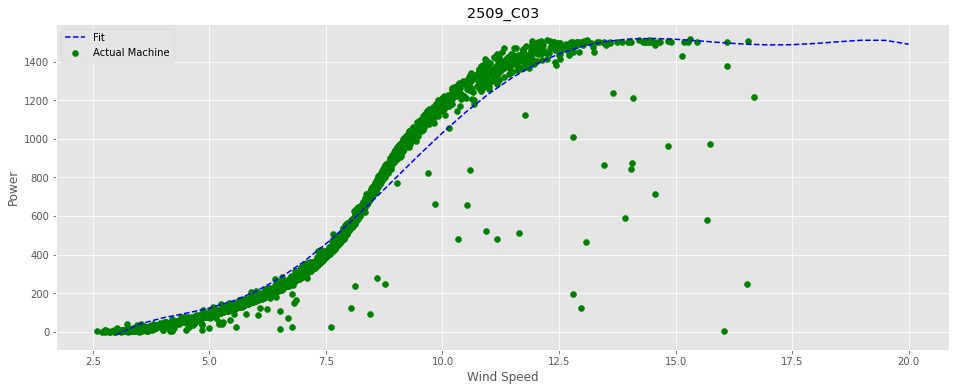

In [393]:
data = pd.read_csv("节能风电-数据题目-风电机组功率曲线异常分类问题/data/2509_C03.csv")
print(data.shape)
print(data[data['ActivePower10min'] == 0].shape)
print(data[data['ActivePower10min'] < 0].shape)
data = data[data['ActivePower10min'] > 0]
print(data.shape)

plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], y_power, '--b')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("2509_C03")
plt.xlabel("Wind Speed")
plt.ylabel("Power")
plt.legend(["Fit", "Actual Machine"])

compare = data.loc[:, ['WindSpeed10min', 'ActivePower10min']]
compare['PredictDesignPower'] = objective(compare['WindSpeed10min'], a, b, c, d, e, f, g)
compare['DiffPower'] = compare['PredictDesignPower'] - compare['ActivePower10min']
compare

In [394]:
compare.describe()

,WindSpeed10min,ActivePower10min,PredictDesignPower,DiffPower
count,3737.000000,3737.000000,3737.000000,3737.000000
mean,7.068485,434.110894,448.627696,14.516802
std,2.267116,406.923092,369.268549,91.062479
min,2.590457,0.031183,-94.424387,-193.701552
25%,5.524778,123.848000,160.923178,-5.407313
50%,6.959221,291.135000,351.358281,34.940945
75%,8.278466,631.659000,626.686301,48.416222
max,16.682546,1516.690000,1520.363874,1493.128065


In [395]:
print(compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5)].shape)
print(compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5) & (compare['DiffPower'] >= 20)].shape)
print(compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5) & (compare['DiffPower'] <= -20)].shape)
low = compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5)].shape[0]
low_posdiff = compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5) & (compare['DiffPower'] >= 20)].shape[0]
low_negdiff = compare[(compare['WindSpeed10min'] >= 2.5) & (compare['WindSpeed10min'] <= 7.5) & (compare['DiffPower'] <= -20)].shape[0]
low_negdiff_ratio = low_negdiff / low
low_posdiff_ratio = low_posdiff / low
print("low_negdiff_ratio: ", low_negdiff_ratio)
print("low_posdiff_ratio: ", low_posdiff_ratio)

print('\n')

print(compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5)].shape)
print(compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5) & (compare['DiffPower'] >= 20)].shape)
print(compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5) & (compare['DiffPower'] <= -20)].shape)
high = compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5)].shape[0]
high_posdiff = compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5) & (compare['DiffPower'] >= 20)].shape[0]
high_negdiff = compare[(compare['WindSpeed10min'] >= 7.5) & (compare['WindSpeed10min'] <= 12.5) & (compare['DiffPower'] <= -20)].shape[0]
high_negdiff_ratio = high_negdiff / high
high_posdiff_ratio = high_posdiff / high
print("high_negdiff_ratio: ", high_negdiff_ratio)
print("high_posdiff_ratio: ", high_posdiff_ratio)

(2263, 4)
(2102, 4)
(25, 4)
low_negdiff_ratio:  0.01104728236853734
low_posdiff_ratio:  0.9288555015466196


(1381, 4)
(380, 4)
(793, 4)
high_negdiff_ratio:  0.5742215785662563
high_posdiff_ratio:  0.27516292541636495


<span style='color:orange;font-weight:bold;font-size:1.5em'>根据上面在低风速和高风速比例的分别统计，可以根据以下规则进行分类：</span> <br/>
1. 低风速区间为[2.5, 7.5], 高风速区间为[7.5, 12.5]
2. 分别统计在低风速和高风速区间内，差值大于20和差值小于-20的比例
3. 按照如下规则分类
    - 右移：低速区正比例大于60%，且高速区正比例大于60%
    - 左移：低速区负比例大于60%，且高速区负比例大于60%
    - 畸变：低速区正比例大于60%，且高速区负比例大于40%
    - 分叉：低速区正比例大于20%且负比例大于20%，高速区正比例大于20%且负比例大于20%
    - 正常：其它情况


# 根据尝试2进行分类结果预测

## 读取数据

In [435]:
curve = pd.read_csv("节能风电-数据题目-风电机组功率曲线异常分类问题/机组设计功率曲线curve.csv")
label = pd.read_csv("节能风电-数据题目-风电机组功率曲线异常分类问题/label.csv")

In [436]:
label.loc[~label['type'].isin(['右移', '分叉', '左移', '畸变']), 'type'] = '正常'
label.columns = ["name", "type"]
label.groupby('type').agg('size')

type
分叉      6
右移      6
左移      6
正常    110
畸变      6
dtype: int64

## 设计机组功率拟合

In [437]:
# 设计机组功率拟合
def objective(x, a, b, c, d, e, f, g):
 return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + (f * x**6) + g

x, y = curve['风速'], curve['功率']
popt, _ = curve_fit(objective, x, y)
a, b, c, d, e, f, g = popt

## 读取所有机组数据

In [438]:
# 读取所有机组数据
import os
data_files = []
for files in os.listdir("节能风电-数据题目-风电机组功率曲线异常分类问题/data"):
    data_files.append("节能风电-数据题目-风电机组功率曲线异常分类问题/data/" + files)
data_files[:3]

['节能风电-数据题目-风电机组功率曲线异常分类问题/data/1101_E16.csv',
 '节能风电-数据题目-风电机组功率曲线异常分类问题/data/1102_E17.csv',
 '节能风电-数据题目-风电机组功率曲线异常分类问题/data/1103_E18.csv']

In [445]:
label.head()

,name,type,pre_type,low_negdiff_ratio,low_posdiff_ratio,high_negdiff_ratio,high_posdiff_ratio
0,1101_E16,右移,NaN,NaN,NaN,NaN,NaN
1,1102_E17,分叉,NaN,NaN,NaN,NaN,NaN
2,1103_E18,正常,NaN,NaN,NaN,NaN,NaN
3,1104_E19,正常,NaN,NaN,NaN,NaN,NaN
4,1105_E20,正常,NaN,NaN,NaN,NaN,NaN


## 遍历循环每组数据进行预测

In [468]:
# 遍历循环每组数据
for path in data_files:
    name = path.split("/")[-1].split(".")[0]
    data = pd.read_csv(path)
    data = data[data['ActivePower10min'] > 0]
    data['PredictDesignPower'] = objective(data['WindSpeed10min'], a, b, c, d, e, f, g)
    data['DiffPower'] = data['PredictDesignPower'] - data['ActivePower10min']
    
    low = data[(data['WindSpeed10min'] >= 2.5) & (data['WindSpeed10min'] <= 7.5)].shape[0]
    low_posdiff = data[(data['WindSpeed10min'] >= 2.5) & (data['WindSpeed10min'] <= 7.5) & (data['DiffPower'] >= 20)].shape[0]
    low_negdiff = data[(data['WindSpeed10min'] >= 2.5) & (data['WindSpeed10min'] <= 7.5) & (data['DiffPower'] <= -20)].shape[0]
    low_negdiff_ratio = low_negdiff / low
    low_posdiff_ratio = low_posdiff / low
    
    high = data[(data['WindSpeed10min'] >= 7.5) & (data['WindSpeed10min'] <= 12.5)].shape[0]
    high_posdiff = data[(data['WindSpeed10min'] >= 7.5) & (data['WindSpeed10min'] <= 12.5) & (data['DiffPower'] >= 20)].shape[0]
    high_negdiff = data[(data['WindSpeed10min'] >= 7.5) & (data['WindSpeed10min'] <= 12.5) & (data['DiffPower'] <= -20)].shape[0]
    high_negdiff_ratio = high_negdiff / high
    high_posdiff_ratio = high_posdiff / high

    if (low_negdiff_ratio > 0.6) & (high_negdiff_ratio > 0.6):
        predict_type = "左移"
    elif (low_posdiff_ratio > 0.6) & (high_posdiff_ratio > 0.6):
        predict_type = "右移"
    elif (low_posdiff_ratio > 0.6) & (high_negdiff_ratio > 0.4):
        predict_type = "畸变"
    elif (low_negdiff_ratio > 0.2) & (high_negdiff_ratio > 0.2) & (low_posdiff_ratio > 0.2) & (high_posdiff_ratio > 0.2):
        predict_type = "分叉"
    else:
        predict_type = "正常"
    
        
    label.loc[label["name"] == name, "pre_type"] = predict_type
    label.loc[label["name"] == name, "low_negdiff_ratio"] = low_negdiff_ratio
    label.loc[label["name"] == name, "low_posdiff_ratio"] = low_posdiff_ratio
    label.loc[label["name"] == name, "high_negdiff_ratio"] = high_negdiff_ratio
    label.loc[label["name"] == name, "high_posdiff_ratio"] = high_posdiff_ratio


## 最终效果

In [469]:
label.head(10)

,name,type,pre_type,low_negdiff_ratio,low_posdiff_ratio,high_negdiff_ratio,high_posdiff_ratio
0,1101_E16,右移,右移,0.016717,0.924989,0.000000,1.000000
1,1102_E17,分叉,分叉,0.365644,0.258982,0.318228,0.670695
2,1103_E18,正常,正常,0.180749,0.141176,0.158730,0.159788
3,1104_E19,正常,正常,0.399325,0.030371,0.241249,0.039735
4,1105_E20,正常,正常,0.209191,0.017279,0.098004,0.201452
5,1106_E21,正常,正常,0.082506,0.064935,0.049049,0.712713
6,1107_F18,正常,正常,0.197126,0.088799,0.235893,0.077706
7,1108_F19,正常,正常,0.188737,0.073059,0.093625,0.351594
8,1109_F20,正常,正常,0.114552,0.045896,0.084191,0.346118
9,1110_F21,正常,正常,0.192587,0.031250,0.147448,0.148393


In [470]:
print(label[label['type'] == label['pre_type']].shape)
print(label.shape)
print(label[label['type'] == label['pre_type']].shape[0] / label.shape[0])

(133, 7)
(134, 7)
0.9925373134328358


In [472]:
label[label['type'] != label['pre_type']]

,name,type,pre_type,low_negdiff_ratio,low_posdiff_ratio,high_negdiff_ratio,high_posdiff_ratio
12,1202_F08,正常,右移,0.002389,0.884854,0.053524,0.811775


## BadCase

(4208, 100)
(478, 100)
(430, 100)
(3300, 100)


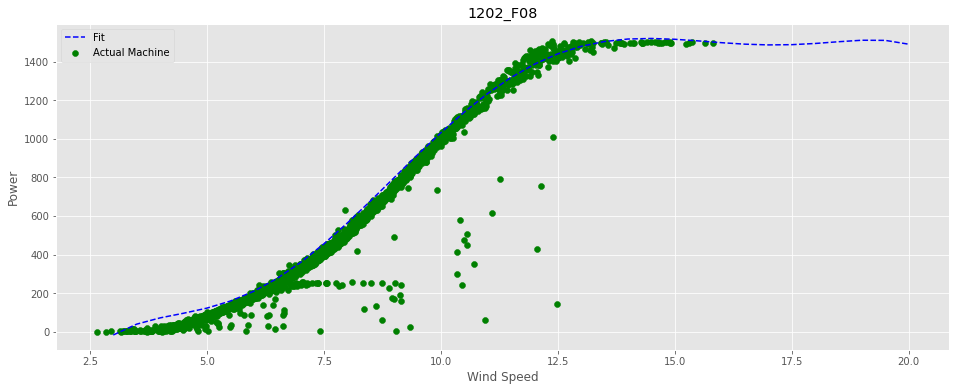

In [473]:
data = pd.read_csv("节能风电-数据题目-风电机组功率曲线异常分类问题/data/1202_F08.csv")
print(data.shape)
print(data[data['ActivePower10min'] == 0].shape)
print(data[data['ActivePower10min'] < 0].shape)
data = data[data['ActivePower10min'] > 0]
print(data.shape)

plt.figure(figsize=(16, 6))
plt.plot(curve['风速'], y_power, '--b')
plt.scatter(data['WindSpeed10min'], data['ActivePower10min'], color='green')
plt.title("1202_F08")
plt.xlabel("Wind Speed")
plt.ylabel("Power")
plt.legend(["Fit", "Actual Machine"])